In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Data Mining Project/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Data Mining Project


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import warnings

In [ ]:
dataset = pd.read_pickle('/content/drive/My Drive/Data Mining Project/dataset/dataset_new.pkl')
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [ ]:
#GRADIENT BOOSTING CLASSIFIER
classifier = GradientBoostingClassifier(n_estimators=100)
warnings.filterwarnings("ignore")

In [ ]:
def dataPreProcess(data, size, startIndex, endIndex, type):
  X = np.zeros([size,21])
  Y = np.zeros(size)
  index = 0
  for customer in range(startIndex, endIndex, 1):
      if(type != 'test'):
        isdef = data[6][customer][1]
      else:
        isdef = 0.
      ts = data[2][customer][1]
      loan_amt = data[4][customer][1]
      loan_date = datetime.strptime(data[5][customer][1],"%Y-%m-%d")
      last_trans_date = datetime.strptime(data[1][customer][1][-1],"%Y-%m-%d")
      first_trans_date = datetime.strptime(data[1][customer][1][0],"%Y-%m-%d")
      last_trans_gap = loan_date - last_trans_date
      first_trans_gap = loan_date - first_trans_date
      cumsum_ts = np.cumsum(ts)
      trans_credit = ts[np.where(ts>0)]
      trans_debit = ts[np.where(ts<0)]
      count = 0
      maxTransactionDate = max(set(data[1][customer][1]), key = data[1][customer][1].count)
      maxTransactionDate = datetime.strptime(maxTransactionDate,"%Y-%m-%d")
      positiveMaxVal = 0.
      positiveMinVal = 0.
      if(trans_credit.shape[0] > 0):
        positiveMaxVal = np.max(trans_credit)
        positiveMinVal = np.min(trans_credit)
      negativeMaxVal = 0.
      negativeMinVal = 0.
      if(trans_debit.shape[0] > 0):
        negativeMinVal = np.min(trans_debit)
        negativeMaxVal = np.max(trans_debit)
      X[index,0] = loan_amt #loan amount
      X[index,1] = np.sum(trans_credit) #total of credit transactions
      X[index,2] = np.sum(trans_debit) #total of debit transactions
      X[index,3] = np.max(ts) #Maximum credited amount
      X[index,4] = np.min(ts) #Maximum debited amount
      X[index,5] = cumsum_ts[-1] #account balance
      X[index,6] = ts.shape[0]  #number of transactions
      X[index,7] = trans_credit.shape[0] #number of credit transactions
      X[index,8] = trans_debit.shape[0] #number of debit transactions
      X[index,9] = positiveMinVal #minimum credited amount
      X[index,10] = positiveMaxVal #maximum credited amount
      X[index,11] = np.mean(trans_credit) #Average of credit transactions
      X[index,12] = np.mean(trans_debit) #Average pf debit transactions
      X[index,13] = abs(last_trans_gap.days) #gap between last transaction and loan date
      X[index,14] = loan_date.year #year of loan request
      X[index,15] = loan_date.month #month of loan request
      X[index,16] = loan_date.day #day of loan request
      X[index,17] = abs(first_trans_gap.days) #gap between first transaction and loan date
      X[index,18] = abs((loan_date - maxTransactionDate).days) #Occurance of max transaction
      X[index,19] = negativeMinVal #minimum debited amount
      X[index,20] = negativeMaxVal #maximum debited amount

      Y[index] = isdef
      index = index + 1

  print('Complete pre-processing', type,' data.....')
  return X, Y 

def dataCleaning(x, type):
  from sklearn.impute import SimpleImputer
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp_mean.fit(x)
  x = imp_mean.transform(x)
  print('Complete cleaning', type,' data.....' )
  return x

def modelScore(clf, x, y, label):
  clf.fit(x,y)
  clf_cvs = cross_validate(clf,x,y,cv=10)
  clf_test_scores = clf_cvs['test_score']
  print(label, 'cross validation score : ', clf_test_scores.mean())

def runtest(clf, X_test, Y_test, label):
  preds = clf.predict_proba(X_test)
  fpr,tpr,thresholds = roc_curve(Y_test,preds[:,1])
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr,tpr)
  plt.plot([0,1],[0,1])
  print(label,' Test AUC: ', roc_auc)

Complete pre-processing train  data.....
Complete cleaning train  data.....
Complete pre-processing validation  data.....
Complete cleaning test  data.....
Gradient Boosting Classifier cross validation score :  0.7705
Gradient Boosting Classifier  Test AUC:  0.7635743321718932


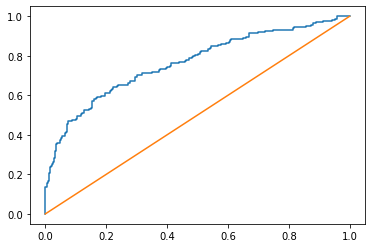

In [ ]:
X_train, Y_train = dataPreProcess(dataset, 10000, 0, 10000, 'train')
X_train = dataCleaning(X_train, 'train')
X_test, Y_test = dataPreProcess(dataset, 500, 10000, 10500, 'validation')
X_test = dataCleaning(X_test, 'test')
modelScore(classifier, X_train, Y_train, 'Gradient Boosting Classifier')
runtest(classifier, X_test, Y_test, 'Gradient Boosting Classifier')

Mean AUC :  0.7520838009726898


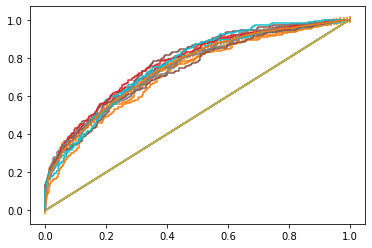

In [ ]:
kfolds = StratifiedKFold(n_splits=10)
mfpr = np.linspace(0, 1, 100)
classifier_tp=[]
classifier_auc=[]

def fit(clf, x_train, y_train, x_test, y_test):
  clf.fit(x_train,y_train)
  preds = clf.predict_proba(x_test)
  fpr,tpr,thresholds = roc_curve(y_test,preds[:,1])
  classifier_tp.append(interp(mfpr, fpr, tpr))
  classifier_tp[-1][0] = 0.0
  roc_auc =  auc(tpr,fpr)
  classifier_auc.append(roc_auc)
  plt.plot([0,1], [0,1])
  plt.plot(fpr, tpr)

def meanCurve():
  mtpr = np.mean(classifier_tp,axis=0)
  m_auc = auc(mfpr,mtpr)
  s_auc = np.std(classifier_auc)
  plt.plot(mfpr,mtpr)
  plt.errorbar(mfpr, mtpr,yerr=s_auc)
  return m_auc

model = classifier #Define model for k-Fold Validatio 
for train_index, test_index in kfolds.split(X_train, Y_train):
  x_train, y_train = X_train[train_index], Y_train[train_index]
  x_test, y_test = X_train[test_index],Y_train[test_index]
  fit(model, x_train, y_train, x_test, y_test)

m_auc = meanCurve()
print('Mean AUC : ',m_auc)

In [ ]:
X_Pred,_ = dataPreProcess(dataset, 5000, 10000, 15000, 'test')
X_Pred = dataCleaning(X_Pred,'test')
Y_pred = classifier.predict_proba(X_Pred)
fileToWrite = open("output.txt", "w")
index = 0
for customer in np.arange(10000,15000):
  customerID=str(dataset[0][customer][1])
  isDefault=str(Y_pred[index][1])
  printline=customerID+','+isDefault+'\n'
  fileToWrite.write(printline)
  index = index+  1
fileToWrite.close()
print('Completed writing predicted probability in output.txt')

Complete pre-processing test  data.....
Complete cleaning test  data.....
Completed writing predicted probability in output.txt
